In [1]:
OUTDATED_IGNORE=1

import pandas as pd 
import pingouin as pg 
import numpy as np 
import matplotlib.pyplot as plt
import pickle
import matplotlib.ticker as ticker

/volatile/miniconda3/envs/ohbm/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/volatile/miniconda3/envs/ohbm/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color='darkgray')
    plt.setp(bp['caps'], color='darkgray')
    plt.setp(bp['medians'], color=color)
    plt.setp(bp['fliers'], color='darkgray', alpha=0.5)

In [4]:
#df = pd.read_csv('../../DerivedData/extracted_metrics/global_cortical_diffusion_metrics.csv', index_col=0)
df = pd.read_csv('../../DerivedData/extracted_metrics/global_cortical_FA_metrics_median_minAD.csv', index_col=0)

info = pd.read_csv('../../DerivedData/cohortA_subjects_clinical.csv', index_col=0)
df = pd.merge(df, info, on=['subject_id'])
df['group'] = 'FT'
df.loc[df['GA_birth'] < 37, 'group'] = 'PT'

with open('../../DerivedData/cohorts_subjects_list.pickle', 'rb') as handle:
    cohorts = pickle.load(handle)

In [7]:
metrics = ['FA']
hemispheres = ['left', 'right']
for metric in metrics:
    for i, row in df.iterrows():
        df.loc[i,metric] = np.mean([row['left_{}'.format(metric)], 
                                   row['right_{}'.format(metric)]])

In [8]:
for i, cohort in enumerate(cohorts.keys()):
    print('Cohort {}:'.format(cohort))
    
    sub_df = df[df.subject_id.isin(cohorts[cohort])]
    
    for label in metrics:
        print('Global {}; {:.6f} ({:.6f}); mean (std); {:.6f} [{:.6f},{:.6f}]; median [range]'.format(
                label, np.mean(sub_df[label].values), np.std(sub_df[label].values), 
            np.median(sub_df[label].values), np.min(sub_df[label].values), np.max(sub_df[label].values)
        
                        ))

Cohort A:
Global FA; 0.097228 (0.008989); mean (std); 0.095749 [0.082451,0.166082]; median [range]
Cohort B:
Global FA; 0.098510 (0.008987); mean (std); 0.096756 [0.082596,0.155454]; median [range]
Cohort C:
Global FA; 0.098505 (0.009028); mean (std); 0.096756 [0.082596,0.155454]; median [range]
Cohort D:
Global FA; 0.097729 (0.008412); mean (std); 0.096756 [0.082596,0.155454]; median [range]


In [9]:
metrics=['FA']

## Global FA PT vs FT 

In [10]:
i = 0
t_res = pd.DataFrame()

print('PT vs FT')
for f, cohort in enumerate(cohorts.keys()):
    #print('Cohort {}:'.format(cohort))
    
    sub_df = df[df.subject_id.isin(cohorts[cohort])]
    #sub_df = df[(df.subject_id.isin(cohorts[cohort])) & (df.PMA_scan >= 37)]
    print(cohort, len(sub_df), len(sub_df[sub_df.group == 'PT']))
    #i = 0
    #t_res = pd.DataFrame()
    for label in metrics:
        ## regress out the 
        lm = pg.linear_regression(sub_df[label], sub_df['PMA_scan'])
        
        sub_df['residual_{}'.format(label)] = lm.residuals_
            
        test = pg.ttest(sub_df[sub_df['group'] == 'PT']['residual_{}'.format(label)].values, 
                       sub_df[sub_df['group'] == 'FT']['residual_{}'.format(label)].values)
        t_res.loc[i, 'cohort'] = cohort
        t_res.loc[i, 'metric'] = label 
        #t_res.loc[i, 'hemi'] = hemi
        t_res.loc[i, 'T'] = test['T'].values[0]
        t_res.loc[i, 'p-val'] = np.float32(test['p-val'].values[0])
        
        i= i+1
    t_res['p-val'] = pg.multicomp(t_res['p-val'].values, method='fdr_bh')[1]
    
t_res

PT vs FT
A 295 43
B 198 39
C 196 39
D 126 21


/volatile/miniconda3/envs/ohbm/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,cohort,metric,T,p-val
0,A,FA,-5.737606,7.092462e-07
1,B,FA,-7.213912,2.281943e-08
2,C,FA,-7.103491,2.281943e-08
3,D,FA,-6.529578,7.092462e-07


## Global FA with outcomes 

In [11]:
scores = ['Cognitive Score', 'Language Score', 'Motor Score']

i=0
res_reg = pd.DataFrame()
for f, cohort in enumerate(cohorts.keys()):
    #print('Cohort {}:'.format(cohort))
    
    sub_df = df[df.subject_id.isin(cohorts[cohort])]

    #i=0
    #res_reg = pd.DataFrame()
    for metric in metrics:
        for score in scores:
            result = pg.corr(sub_df[metric].values,
                        sub_df[score].values)
        
            res_reg.loc[i, 'cohort'] = cohort
            res_reg.loc[i, 'score'] = score
            res_reg.loc[i, 'metric'] = metric
            #res_reg.loc[i, 'hemi'] = hemi
            res_reg.loc[i, 'r'.format(score)] = np.round(np.float32(result.r),2)
            res_reg.loc[i, 'p-val'.format(score)] = np.float64(result['p-val'])
        #res_reg.loc[i, 'p-val'] = np.float64(result.pval[1])
            i = i+1
  

#labels = [label+'_p-val' for label in scores]

pvals = pg.multicomp(res_reg['p-val'].values.ravel(), method='fdr_bh')[1]
pvals = pvals.reshape(np.shape(res_reg['p-val'].values))
res_reg['p-val'] = pvals
#print(res_reg)
#res_reg.to_csv('outcomes_cohort_{}'.format(cohort))

In [14]:
res_reg = res_reg[res_reg.cohort.isin(['A', 'C', 'D'])]
pd.pivot_table(res_reg,  index=['metric'], columns=['cohort', 'score']).sort_index(axis=1)

p-val                                             \
cohort               A                                          C   
score  Cognitive Score Language Score Motor Score Cognitive Score   
metric                                                              
FA            0.994367       0.994367    0.994367        0.994367   

                                                                              \
cohort                                          D                              
score  Language Score Motor Score Cognitive Score Language Score Motor Score   
metric                                                                         
FA           0.994367    0.994367        0.994367       0.994367    0.994367   

                     r                                             \
cohort               A                                          C   
score  Cognitive Score Language Score Motor Score Cognitive Score   
metric                                                              
FA               -0.06          -0.03       -0.03             0.0   

                                                                              
cohort                                          D                             
score  Language Score Motor Score Cognitive Score Language Score Motor Score  
metric                                                                        
FA               0.02        0.03           -0.04          -0.01        0.01

In [15]:
res_reg

,cohort,score,metric,r,p-val
0,A,Cognitive Score,FA,-0.06,0.994367
1,A,Language Score,FA,-0.03,0.994367
2,A,Motor Score,FA,-0.03,0.994367
6,C,Cognitive Score,FA,-0.00,0.994367
7,C,Language Score,FA,0.02,0.994367
8,C,Motor Score,FA,0.03,0.994367
9,D,Cognitive Score,FA,-0.04,0.994367
10,D,Language Score,FA,-0.01,0.994367
11,D,Motor Score,FA,0.01,0.994367


### PT and FT independentl

In [16]:
scores = ['Cognitive Score', 'Language Score', 'Motor Score']

group = 'PT'
print(group)
i=0
res_reg = pd.DataFrame()
for f, cohort in enumerate(cohorts.keys()):
    #print('Cohort {}:'.format(cohort))
    
    sub_df = df[df.subject_id.isin(cohorts[cohort])]
    sub_df = sub_df[sub_df.group == group]
    #i=0
    #res_reg = pd.DataFrame()
    for metric in metrics:
        for score in scores:
            result = pg.corr(sub_df[metric].values,
                        sub_df[score].values)
        
            res_reg.loc[i, 'cohort'] = cohort
            res_reg.loc[i, 'score'] = score
            res_reg.loc[i, 'metric'] = metric
            #res_reg.loc[i, 'hemi'] = hemi
            res_reg.loc[i, 'r'.format(score)] = np.round(np.float32(result.r),2)
            res_reg.loc[i, 'p-val'.format(score)] = np.float64(result['p-val'])
        #res_reg.loc[i, 'p-val'] = np.float64(result.pval[1])
            i = i+1
  

#labels = [label+'_p-val' for label in scores]

pvals = pg.multicomp(res_reg['p-val'].values.ravel(), method='fdr_bh')[1]
pvals = pvals.reshape(np.shape(res_reg['p-val'].values))
res_reg['p-val'] = pvals
#print(res_reg)
#res_reg.to_csv('outcomes_cohort_{}'.format(cohort))

pd.pivot_table(res_reg,  index=['metric'], columns=['cohort', 'score']).sort_index(axis=1)

PT


p-val                                             \
cohort               A                                          B   
score  Cognitive Score Language Score Motor Score Cognitive Score   
metric                                                              
FA            0.963922       0.963922    0.963922        0.963922   

                                                                              \
cohort                                          C                              
score  Language Score Motor Score Cognitive Score Language Score Motor Score   
metric                                                                         
FA           0.963922    0.963922        0.963922       0.963922    0.963922   

                        ...           r                                 \
cohort               D  ...           A               B                  
score  Cognitive Score  ... Motor Score Cognitive Score Language Score   
metric                  ...                                              
FA            0.963922  ...       -0.08           -0.02           0.06   

                                                                               \
cohort                           C                                          D   
score  Motor Score Cognitive Score Language Score Motor Score Cognitive Score   
metric                                                                          
FA           -0.01           -0.02           0.06       -0.01           -0.05   

                                   
cohort                             
score  Language Score Motor Score  
metric                             
FA               0.02       -0.06  

[1 rows x 24 columns]

In [17]:
res_reg

,cohort,score,metric,r,p-val
0,A,Cognitive Score,FA,-0.06,0.963922
1,A,Language Score,FA,0.03,0.963922
2,A,Motor Score,FA,-0.08,0.963922
3,B,Cognitive Score,FA,-0.02,0.963922
4,B,Language Score,FA,0.06,0.963922
5,B,Motor Score,FA,-0.01,0.963922
6,C,Cognitive Score,FA,-0.02,0.963922
7,C,Language Score,FA,0.06,0.963922
8,C,Motor Score,FA,-0.01,0.963922
9,D,Cognitive Score,FA,-0.05,0.963922


In [18]:
scores = ['Cognitive Score', 'Language Score', 'Motor Score']

group = 'FT'
print(group)
i=0
res_reg = pd.DataFrame()
for f, cohort in enumerate(cohorts.keys()):
    #print('Cohort {}:'.format(cohort))
    
    sub_df = df[df.subject_id.isin(cohorts[cohort])]
    sub_df = sub_df[sub_df.group == group]
    #i=0
    #res_reg = pd.DataFrame()
    for metric in metrics:
        for score in scores:
            result = pg.corr(sub_df[metric].values,
                        sub_df[score].values)
        
            res_reg.loc[i, 'cohort'] = cohort
            res_reg.loc[i, 'score'] = score
            res_reg.loc[i, 'metric'] = metric
            #res_reg.loc[i, 'hemi'] = hemi
            res_reg.loc[i, 'r'.format(score)] = np.round(np.float32(result.r),2)
            res_reg.loc[i, 'p-val'.format(score)] = np.float64(result['p-val'])
        #res_reg.loc[i, 'p-val'] = np.float64(result.pval[1])
            i = i+1
  

#labels = [label+'_p-val' for label in scores]

pvals = pg.multicomp(res_reg['p-val'].values.ravel(), method='fdr_bh')[1]
pvals = pvals.reshape(np.shape(res_reg['p-val'].values))
res_reg['p-val'] = pvals
#print(res_reg)
#res_reg.to_csv('outcomes_cohort_{}'.format(cohort))

pd.pivot_table(res_reg,  index=['metric'], columns=['cohort', 'score']).sort_index(axis=1)

FT


p-val                                             \
cohort               A                                          B   
score  Cognitive Score Language Score Motor Score Cognitive Score   
metric                                                              
FA            0.377841       0.377841    0.601329        0.377841   

                                                                              \
cohort                                          C                              
score  Language Score Motor Score Cognitive Score Language Score Motor Score   
metric                                                                         
FA           0.377841    0.377841        0.377841       0.377841    0.377841   

                        ...           r                                 \
cohort               D  ...           A               B                  
score  Cognitive Score  ... Motor Score Cognitive Score Language Score   
metric                  ...                                              
FA            0.377841  ...        0.04           -0.09          -0.08   

                                                                               \
cohort                           C                                          D   
score  Motor Score Cognitive Score Language Score Motor Score Cognitive Score   
metric                                                                          
FA             0.1           -0.09          -0.08        0.09           -0.12   

                                   
cohort                             
score  Language Score Motor Score  
metric                             
FA              -0.11        0.02  

[1 rows x 24 columns]

In [19]:
res_reg

,cohort,score,metric,r,p-val
0,A,Cognitive Score,FA,-0.12,0.377841
1,A,Language Score,FA,-0.10,0.377841
2,A,Motor Score,FA,0.04,0.601329
3,B,Cognitive Score,FA,-0.09,0.377841
4,B,Language Score,FA,-0.08,0.377841
5,B,Motor Score,FA,0.10,0.377841
6,C,Cognitive Score,FA,-0.09,0.377841
7,C,Language Score,FA,-0.08,0.377841
8,C,Motor Score,FA,0.09,0.377841
9,D,Cognitive Score,FA,-0.12,0.377841


# Plotting the correction for PMA at scan

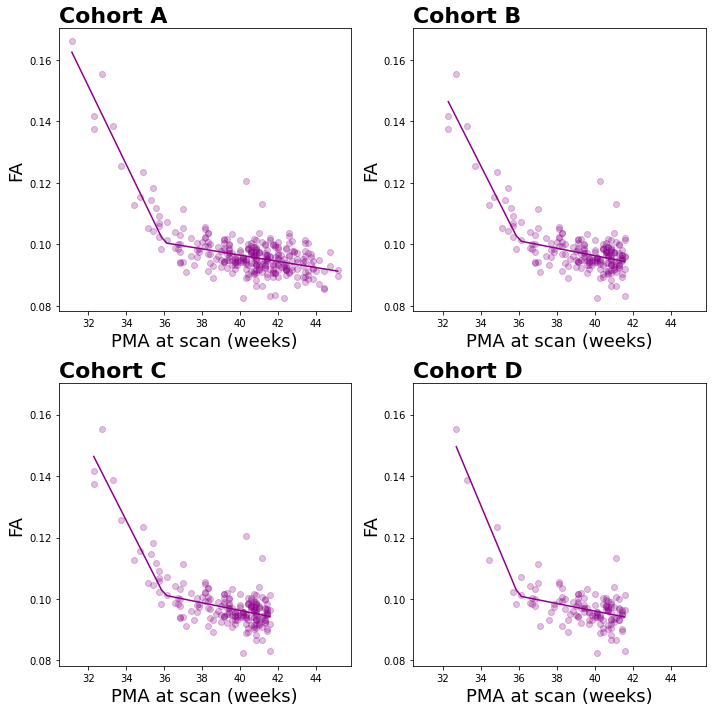

In [24]:
import pwlf
fig, axs = plt.subplots(2,2, figsize=(10,10), sharex=True, sharey=True)#, sharey='row')
axs = axs.ravel()
#for f, cohort in enumerate(cohorts.keys()):
for f, cohort in enumerate(['A', 'B', 'C', 'D']):
    #print('Cohort {}:'.format(cohort))
    sub_df = df[df.subject_id.isin(cohorts[cohort])]

    metric = 'FA'
    
    axs[f].scatter(sub_df['PMA_scan'].values, sub_df[metric].values, c='darkmagenta', alpha=0.25)

    x0 = np.array([min(sub_df['PMA_scan'].values), 36, max(sub_df['PMA_scan'].values)])
    myPWLF = pwlf.PiecewiseLinFit(sub_df['PMA_scan'].values,sub_df['FA'].values)
    myPWLF.fit_with_breaks(x0)
    
    inX = np.sort(sub_df['PMA_scan'].values)
    yHat = myPWLF.predict(inX)
    
    axs[f].plot(inX, yHat, '-', c='darkmagenta' )

    axs[f].xaxis.set_tick_params(which='both', labelbottom=True)
    axs[f].yaxis.set_tick_params(which='both', labelbottom=True)
    axs[f].set_xlabel('PMA at scan (weeks)', fontsize=18)
    axs[f].set_ylabel(f'FA', fontsize=18)
    axs[f].set_title('Cohort {}'.format(cohort), fontsize=22, loc='left', fontweight='bold')

plt.tight_layout()
plt.savefig('../../Results/sanity_check_minAD/lr_global_FA_with_PMA_cohorts.jpg', dpi=500)
plt.show()

## plot per region

In [26]:
diff = pd.read_csv('../../DerivedData/extracted_metrics/neonat_segmentation_FA_median_minAD.csv', index_col=0)

FA_cols = [col for col in diff.columns if 'FA' in col]
FA_cols.extend(['subject_id'])

new_df = sub_df.copy()
new_df = pd.merge(new_df, diff[FA_cols], on=['subject_id'])

FA_cols.extend(['PMA_scan'])
inX = new_df[FA_cols].values

In [27]:
scheme = pd.read_csv('../../SourceData/atlas_labelling_scheme.csv')
lbs = [name.split('_')[1] for name in FA_cols[:-2]]
names = [scheme[scheme.Label == int(l)]['Abbreviation'].values[0] + ' ' +  scheme[scheme.Label == int(l)]['Hemisphere'].values[0]for l in lbs]

In [28]:
inflection = 36

outX = np.zeros_like(inX)

for idx, col in enumerate(FA_cols[:-2]):
    
    x0 = np.array([min(inX[:,-1]), inflection, max(inX[:,-1])])    
    col_median = np.nanmedian(inX[:,idx].astype(np.float32))
    indices = np.where(pd.isna(inX[:,idx]))
    for n in indices: 
        inX[n, idx] = col_median
    
    ### fit the corrector
    myPWLF = pwlf.PiecewiseLinFit(inX[:,-1].astype(np.float32), inX[:,idx].astype(np.float32))
    myPWLF.fit_with_breaks(x0)
    
    ages = np.empty_like(inX[:,-1])
    ages[:] = 40
    
    TEA = myPWLF.predict(ages)
    yHat = myPWLF.predict(inX[:,-1])
    
    res = inX[:,idx] - yHat
    
    outX[:,idx] = res + TEA
    

In [32]:
## median FA regions 
diff = pd.read_csv('../../DerivedData/extracted_metrics/neonat_segmentation_FA_median_minAD.csv', index_col=0)

FA_cols = [col for col in diff.columns if 'FA' in col]
FA_cols.extend(['subject_id'])

new_df = sub_df.copy()
new_df = pd.merge(new_df, diff[FA_cols], on=['subject_id'])

FA_cols.extend(['PMA_scan'])
inX = new_df[FA_cols].values


In [33]:
inflection = 36

outX_res = np.zeros_like(inX)
outX_res_40 = np.zeros_like(inX)

for idx, col in enumerate(FA_cols[:-2]):
    
    x0 = np.array([min(inX[:,-1]), inflection, max(inX[:,-1])])    
    col_median = np.nanmedian(inX[:,idx].astype(np.float32))
    indices = np.where(pd.isna(inX[:,idx]))
    for n in indices: 
        inX[n, idx] = col_median
    
    ### fit the corrector
    myPWLF = pwlf.PiecewiseLinFit(inX[:,-1].astype(np.float32), inX[:,idx].astype(np.float32))
    myPWLF.fit_with_breaks(x0)
    
    ages = np.empty_like(inX[:,-1])
    ages[:] = 40
    
    TEA = myPWLF.predict(ages)
    yHat = myPWLF.predict(inX[:,-1])
    
    res = inX[:,idx] - yHat
    
    outX_res[:,idx] = res
    outX_res_40[:,idx] = res + TEA

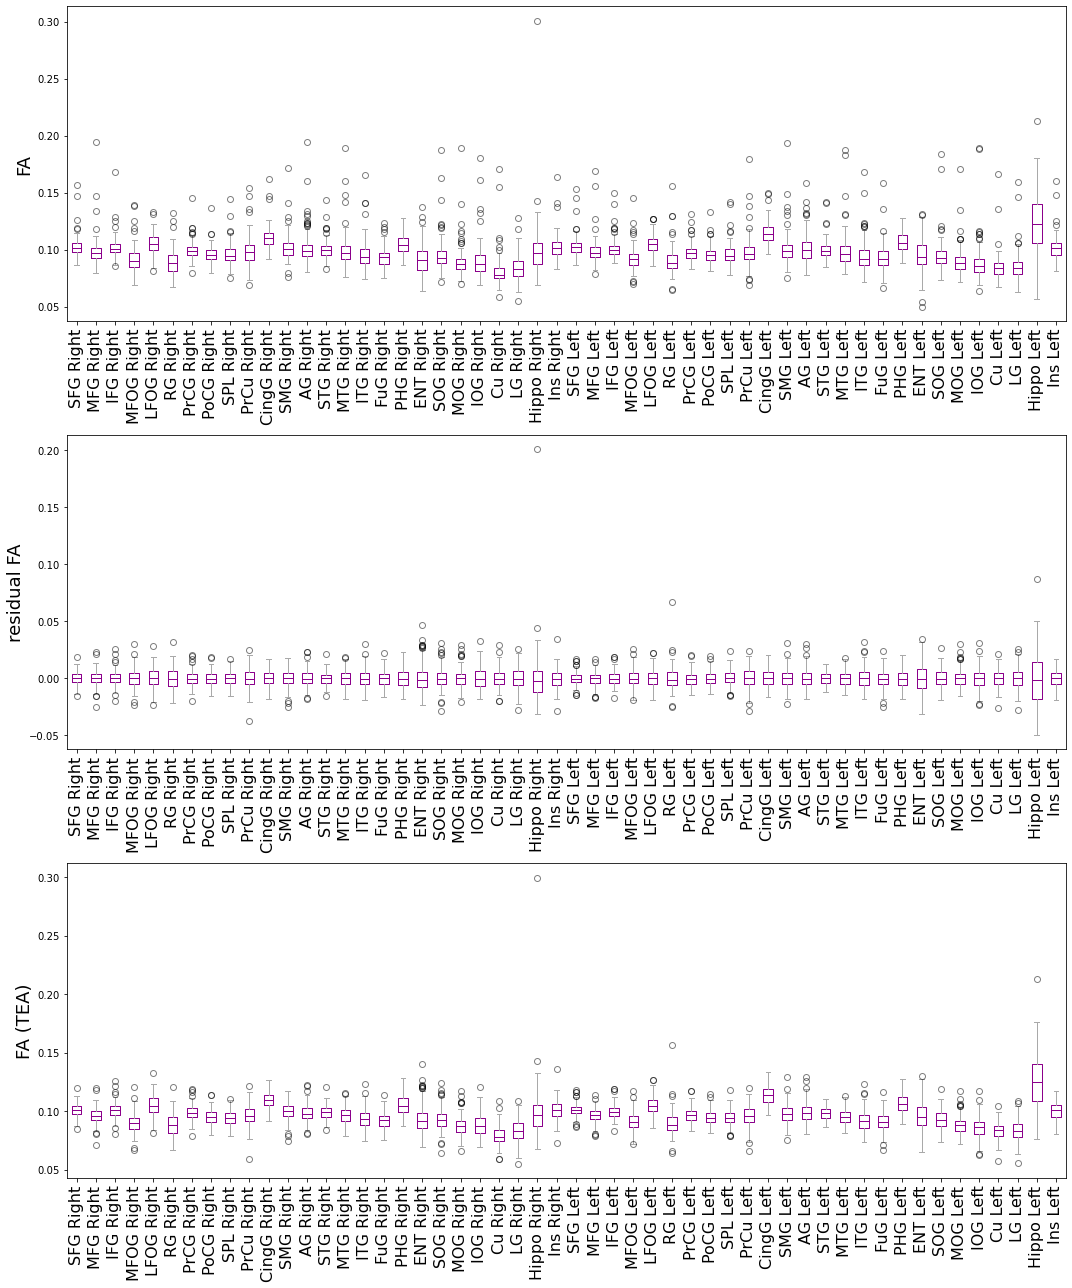

In [34]:
fig, axs = plt.subplots(3,1,figsize=(15,18))

for idx in FA_cols[:-2]:
    new_df[idx].fillna(new_df[idx].median(), inplace=True)

bpl = axs[0].boxplot([ new_df[idx].values for idx in FA_cols[:-2]], positions= range(len(FA_cols[:-2])), 
            labels=names, )
set_box_color(bpl, 'darkmagenta')

bpl = axs[1].boxplot([ outX_res[:, idx] for idx in range(len(FA_cols[:-2]))], positions= range(len(FA_cols[:-2])), 
            labels=names, )
set_box_color(bpl, 'darkmagenta')

bpl = axs[2].boxplot([ outX_res_40[:, idx] for idx in range(len(FA_cols[:-2]))], positions= range(len(FA_cols[:-2])), 
            labels=names, )
set_box_color(bpl, 'darkmagenta')


for ax, label in zip(axs, ['FA', 'residual FA', 'FA (TEA)']):
    #axs[0].set_xticks( fontsize=14)
    ax.xaxis.set_tick_params(labelrotation=90, labelsize=16)
    ax.set_ylabel(label, fontsize=18 )


plt.tight_layout()
plt.savefig('../../Results/sanity_check_minAD/FA_distribution_cohortA.png', dpi=500, facecolor='white', transparent=False)
plt.show()

## paired comparison

In [35]:
pre =  pd.read_csv('../../DerivedData/extracted_metrics/neonat_segmentation_diffusion_metric_median.csv', index_col=0)
post =  pd.read_csv('../../DerivedData/extracted_metrics/neonat_segmentation_FA_median_minAD.csv', index_col=0)

In [47]:
ps = []
for col in FA_cols[:-2]:
    res = pg.ttest(pre[col].values, post[col].values, paired=True)
    ps.append(res['p-val'].values[0].astype(np.float64))


In [50]:
pvals = pg.multicomp(ps, method='fdr_bh')
print(pvals)

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True]), array([4.05467283e-141, 5.06473884e-104, 2.08677623e-175, 3.76498848e-171,
       1.38393665e-249, 3.80315825e-163, 3.23107534e-172, 1.64724011e-196,
       7.11119078e-135, 6.75254593e-117, 3.25737639e-220, 8.06533384e-125,
       4.63961069e-111, 1.01125113e-168, 7.68819320e-108, 2.43343872e-134,
       1.70367922e-201, 3.70391858e-258, 1.33917665e-199, 4.58015962e-093,
       3.25354187e-110, 1.27888994e-113, 2.65668949e-111, 3.51174323e-142,
       1.97175001e-112, 9.35141484e-156, 2.99060482e-150, 5.05265227e-114,
       6.98775055e-153, 7.11620739e-175, 5.33862255e-252, 2.554665

## cohort C (similar distributions) 

In [51]:
## median FA regions 
diff = pd.read_csv('../../DerivedData/extracted_metrics/neonat_segmentation_FA_median_minAD.csv', index_col=0)
diff = diff[diff.subject_id.isin(cohorts[cohort])]

FA_cols = [col for col in diff.columns if 'FA' in col]
FA_cols.extend(['subject_id'])

new_df = sub_df.copy()
new_df = pd.merge(new_df, diff[FA_cols], on=['subject_id'])

FA_cols.extend(['PMA_scan'])
inX = new_df[FA_cols].values

inflection = 36

outX_res = np.zeros_like(inX)
outX_res_40 = np.zeros_like(inX)

for idx, col in enumerate(FA_cols[:-2]):
    
    x0 = np.array([min(inX[:,-1]), inflection, max(inX[:,-1])])    
    col_median = np.nanmedian(inX[:,idx].astype(np.float32))
    indices = np.where(pd.isna(inX[:,idx]))
    for n in indices: 
        inX[n, idx] = col_median
    
    ### fit the corrector
    myPWLF = pwlf.PiecewiseLinFit(inX[:,-1].astype(np.float32), inX[:,idx].astype(np.float32))
    myPWLF.fit_with_breaks(x0)
    
    ages = np.empty_like(inX[:,-1])
    ages[:] = 40
    
    TEA = myPWLF.predict(ages)
    yHat = myPWLF.predict(inX[:,-1])
    
    res = inX[:,idx] - yHat
    
    outX_res[:,idx] = res
    outX_res_40[:,idx] = res + TEA


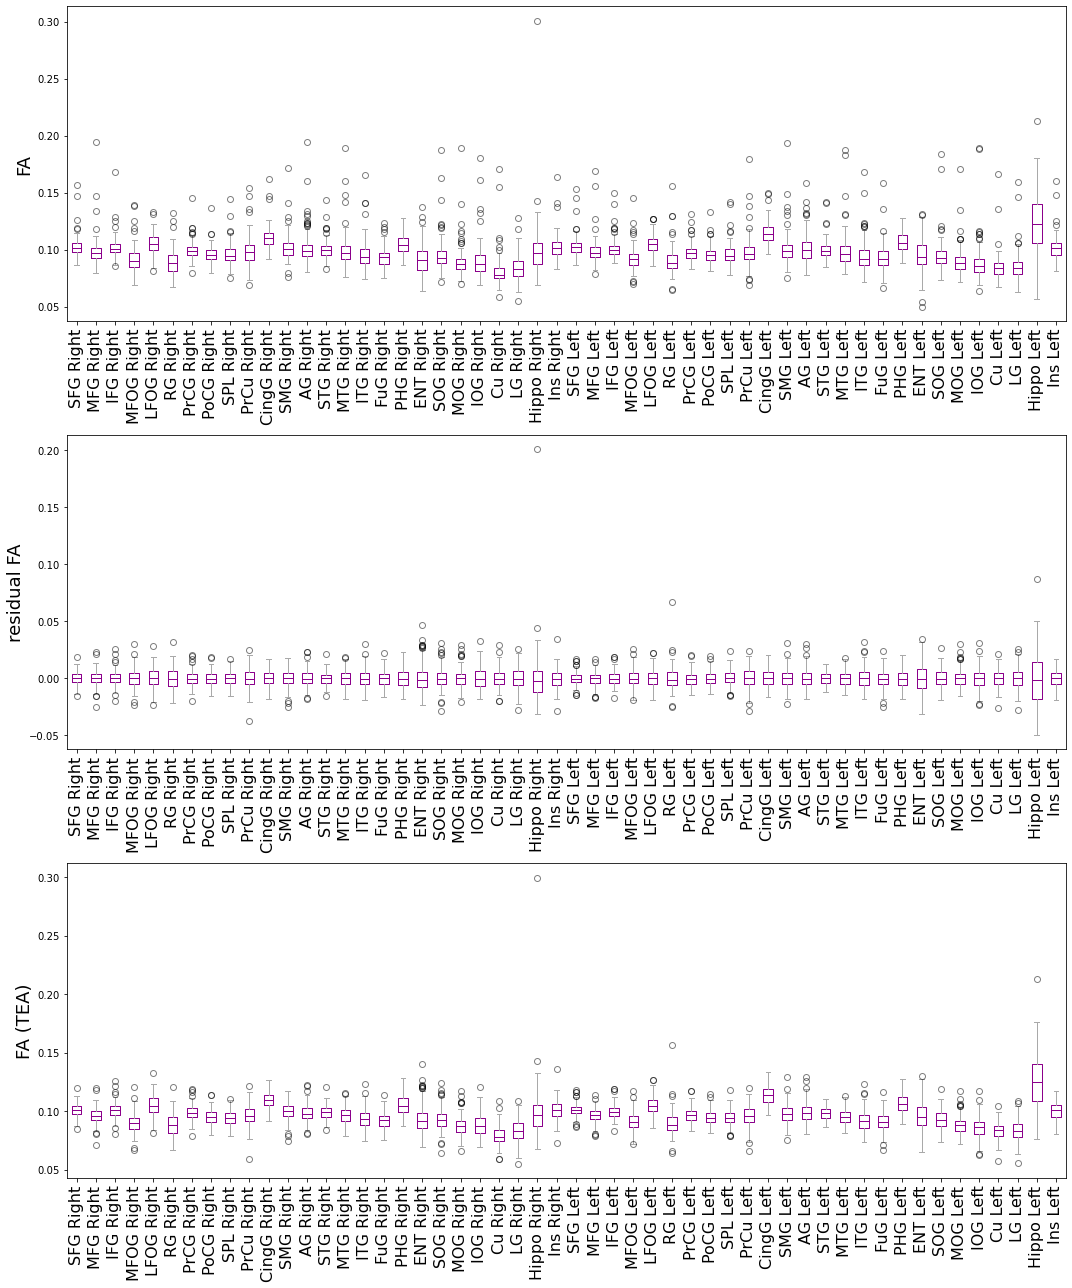

In [52]:
fig, axs = plt.subplots(3,1,figsize=(15,18))

for idx in FA_cols[:-2]:
    new_df[idx].fillna(new_df[idx].median(), inplace=True)

bpl = axs[0].boxplot([ new_df[idx].values for idx in FA_cols[:-2]], positions= range(len(FA_cols[:-2])), 
            labels=names, )
set_box_color(bpl, 'darkmagenta')

bpl = axs[1].boxplot([ outX_res[:, idx] for idx in range(len(FA_cols[:-2]))], positions= range(len(FA_cols[:-2])), 
            labels=names, )
set_box_color(bpl, 'darkmagenta')

bpl = axs[2].boxplot([ outX_res_40[:, idx] for idx in range(len(FA_cols[:-2]))], positions= range(len(FA_cols[:-2])), 
            labels=names, )
set_box_color(bpl, 'darkmagenta')


for ax, label in zip(axs, ['FA', 'residual FA', 'FA (TEA)']):
    #axs[0].set_xticks( fontsize=14)
    ax.xaxis.set_tick_params(labelrotation=90, labelsize=16)
    ax.set_ylabel(label, fontsize=18 )


plt.tight_layout()
plt.savefig('../../Results/sanity_check_minAD/FA_distribution_cohortC.png', dpi=500, facecolor='white', transparent=False)
plt.show()

## Quantify overlap &  feature collinearity

#### GLOBAL

In [56]:

from scipy.stats import gaussian_kde

/volatile/miniconda3/envs/ohbm/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/volatile/miniconda3/envs/ohbm/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Number of at PT subjects: 43 vs FT: 252
Cognitive Score: number of at risk subjects: 24 vs normal: 271
Language Score: number of at risk subjects: 57 vs normal: 238
Motor Score: number of at risk subjects: 21 vs normal: 274


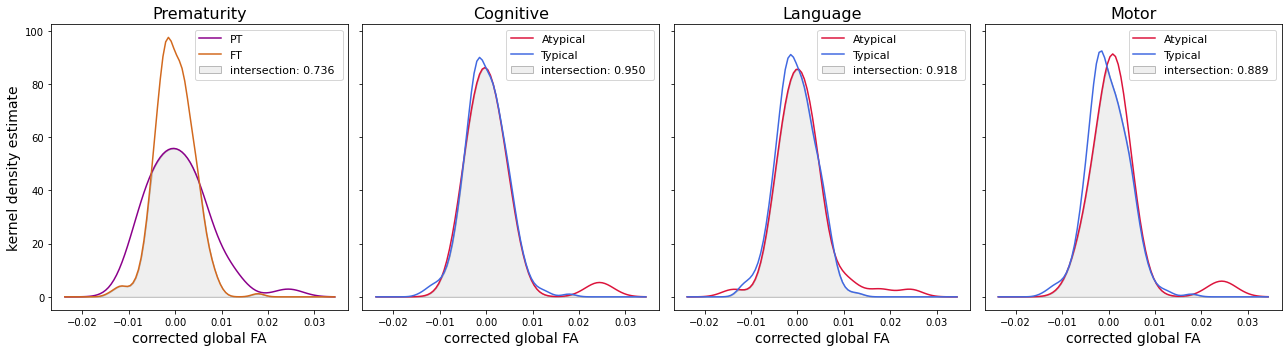

In [57]:
df = pd.read_csv('../../DerivedData/extracted_metrics/global_cortical_FA_metrics_median_minAD.csv', index_col=0)
info = pd.read_csv('../../DerivedData/cohortA_subjects_clinical.csv', index_col=0)
df = pd.merge(df, info, on=['subject_id', 'session_id'])
df['group'] = 'FT'
df.loc[df['GA_birth'] < 37, 'group'] = 'PT'
### combine hemispheres 
metrics = ['FA']#, 'L1', 'RD', 'MD']
hemispheres = ['left', 'right']
for metric in metrics:
    for i, row in df.iterrows():
        df.loc[i,metric] = np.mean([row['left_{}'.format(metric)], 
                                   row['right_{}'.format(metric)]])
        
        
sub_df = df[df.subject_id.isin(cohorts['A'])]

middle = 36
x0 = np.array([min(sub_df['PMA_scan'].values), middle, max(sub_df['PMA_scan'].values)])
myPWLF = pwlf.PiecewiseLinFit(sub_df['PMA_scan'].values,sub_df['FA'].values)
myPWLF.fit_with_breaks(x0)

yHat = myPWLF.predict(sub_df['PMA_scan'].values)
residuals = sub_df['FA'].values - yHat

sub_df['FA_corr'] = residuals.tolist()


abn = sub_df[sub_df['group'] == 'PT']['FA_corr'].values
nrm = sub_df[sub_df['group'] == 'FT']['FA_corr'].values

print('Number of at PT subjects: {} vs FT: {}'.format(len(abn), len(nrm)))
    
x = np.linspace(np.min(sub_df['FA_corr'].values)-0.01,np.max(sub_df['FA_corr'].values+0.01),100)
ys = []

fig, axs = plt.subplots(1,4, sharex=True, sharey=True, figsize=(18, 5))


for cond, label, color in zip([abn, nrm], ['PT', 'FT'], ['darkmagenta', 'chocolate']):
    kde_func = gaussian_kde(cond)
    y = kde_func(x)
    axs[0].plot(x, y, label=label, c=color)
    ys.append(y)
        
y_intersection = np.amin(ys, axis=0)
area = np.trapz(y_intersection, x)
fill_poly = axs[0].fill_between(x, 0, y_intersection, fc='silver', ec='black', alpha=0.25,
                             label=f'intersection: {area:.3f} ')
axs[0].legend(loc='upper right', fontsize=11)
        
#plt.title('PT vs FT: global FA overlap'.format(score), fontsize=16)
axs[0].set_title('Prematurity', fontsize=16)
axs[0].set_xlabel('corrected global FA', fontsize=14)
axs[0].set_ylabel('kernel density estimate', fontsize=14)

sub_df = df[df.subject_id.isin(cohorts['A'])]

### age correction
middle = 36
x0 = np.array([min(sub_df['PMA_scan'].values), middle, max(sub_df['PMA_scan'].values)])
myPWLF = pwlf.PiecewiseLinFit(sub_df['PMA_scan'].values,sub_df['FA'].values)
myPWLF.fit_with_breaks(x0)

yHat = myPWLF.predict(sub_df['PMA_scan'].values)
residuals = sub_df['FA'].values - yHat

sub_df['FA_corr'] = residuals.tolist()
###

#fig, axs = plt.subplots(1,3, sharex=True, sharey=True, figsize=(18, 5))

names = ['Cognitive', 'Language', 'Motor']

for p, score in enumerate(['Cognitive Score', 'Language Score', 'Motor Score']):
    pos = p + 1 
    
    abn = sub_df[sub_df[score] <= 85]['FA_corr'].values
    nrm = sub_df[sub_df[score] > 85]['FA_corr'].values

    print('{}: number of at risk subjects: {} vs normal: {}'.format(score, len(abn), len(nrm)))
    
    x = np.linspace(np.min(sub_df['FA_corr'].values)-0.01,np.max(sub_df['FA_corr'].values+0.01),100)
    ys = []
    for cond, label, color in zip([abn, nrm], ['Atypical', 'Typical'], ['crimson', 'royalblue']):
        kde_func = gaussian_kde(cond)
        y = kde_func(x)
        axs[pos].plot(x, y, label=label, c=color)
        ys.append(y)
        
    y_intersection = np.amin(ys, axis=0)
    area = np.trapz(y_intersection, x)
    fill_poly = axs[pos].fill_between(x, 0, y_intersection, fc='silver', ec='black', alpha=0.25,
                             label=f'intersection: {area:.3f} ')
    axs[pos].legend(loc='upper right', fontsize=11)
        
    axs[pos].set_title(names[p], fontsize=16)
    axs[pos].set_xlabel('corrected global FA', fontsize=14)
    #axs[pos].set_ylabel('kernel density estimate', fontsize=14)


plt.tight_layout()
plt.savefig('../../Results/sanity_check_minAD/overlap_preterm_cohortA.png', dpi=500, facecolor='white', transparent=False)
plt.show() 


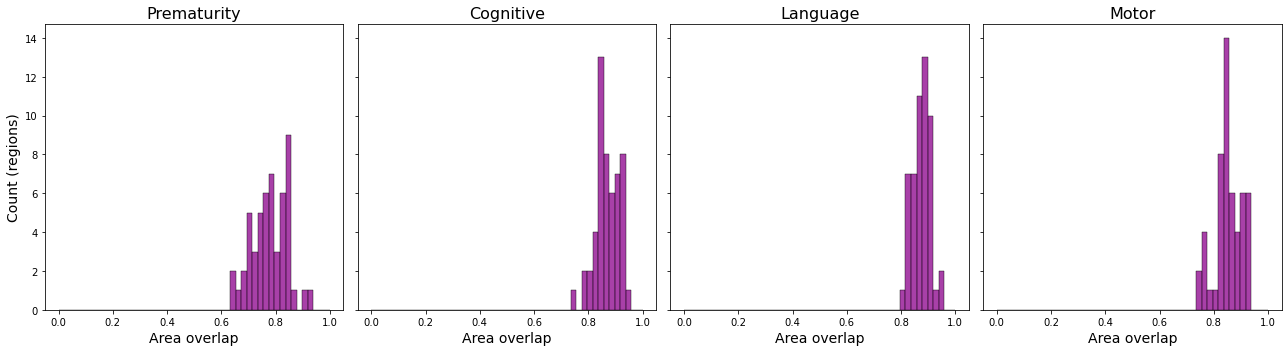

In [59]:
## per segmented region
import seaborn as sns
df = pd.read_csv('../../DerivedData/extracted_metrics/neonat_segmentation_FA_median_minAD.csv', index_col=0)

cols = [col for col in df.columns if 'FA' in col]
df = df[df.subject_id.isin(cohorts['A'])]
scheme = pd.read_csv('../../SourceData/atlas_labelling_scheme.csv')

lbs = [name.split('_')[1] for name in cols]
names = [scheme[scheme.Label == int(l)]['Abbreviation'].values[0] + ' ' +  scheme[scheme.Label == int(l)]['Hemisphere'].values[0]for l in lbs]
df = pd.merge(df, info[['subject_id', 'session_id','GA_birth', 'PMA_scan']], on=['subject_id', 'session_id'])

df['group'] = 'FT'
df.loc[df['GA_birth'] < 37, 'group'] = 'PT'

res = []

sub_df = df[df.subject_id.isin(cohorts['A'])]

### age correction needs to be done per column
middle = 36
x0 = np.array([np.nanmin(sub_df['PMA_scan'].values), middle, np.nanmax(sub_df['PMA_scan'].values)])

for col in cols:
    
    ### unpute median 
    md = np.nanmedian(sub_df[col].values)
    sub_df[col].fillna(md, inplace=True)
    
    
    myPWLF = pwlf.PiecewiseLinFit(sub_df['PMA_scan'].values,sub_df[col].values)
    myPWLF.fit_with_breaks(x0)
    
    yHat = myPWLF.predict(sub_df['PMA_scan'].values)
    residuals = sub_df[col].values - yHat

    sub_df[col+'_corr'] = residuals.tolist()

for col in cols: 
    
    col = col+'_corr'
    abn = sub_df[sub_df['group'] == 'PT'][col].values
    nrm = sub_df[sub_df['group'] == 'FT'][col].values
    abn = abn[~np.isnan(abn)]
    nrm = nrm[~np.isnan(nrm)]
    x = np.linspace(np.nanmin(sub_df[col].values)-0.01,np.nanmax(sub_df[col].values+0.01),100)
    ys = []
    for cond, label, color in zip([abn, nrm], ['At risk', 'Normal'], ['darkmagenta', 'chocolate']):
        kde_func = gaussian_kde(cond[~np.isnan(cond)])
        y = kde_func(x)
        ys.append(y)
        
    y_intersection = np.amin(ys, axis=0)
    area = np.trapz(y_intersection, x)
        
    res.append(area)
 
fig, axs = plt.subplots(1,4, sharex=True, sharey=True, figsize=(18, 5))

sns.histplot(res, kde=False, bins=np.linspace(0,1,50), color='darkmagenta', ax=axs[0])
axs[0].set_title('Prematurity'.format(score), fontsize=16)
axs[0].set_xlabel('Area overlap', fontsize=14)
axs[0].set_ylabel('Count (regions)', fontsize=14)

df = pd.read_csv('../../DerivedData/extracted_metrics/neonat_segmentation_diffusion_metric_median.csv', index_col=0)

cols = [col for col in df.columns if 'FA' in col]
df = df[df.subject_id.isin(cohorts['A'])]
scheme = pd.read_csv('../../SourceData/atlas_labelling_scheme.csv')

lbs = [name.split('_')[1] for name in cols]
names = [scheme[scheme.Label == int(l)]['Abbreviation'].values[0] + ' ' +  scheme[scheme.Label == int(l)]['Hemisphere'].values[0]for l in lbs]
df = pd.merge(df, info[['subject_id', 'session_id','Cognitive Score', 'Language Score', 'Motor Score']], on=['subject_id', 'session_id'])

### get PMA at scan 
info = pd.read_csv('../../DerivedData/cohortA_subjects_clinical.csv', index_col=0)
df = pd.merge(df, info[['subject_id', 'session_id', 'PMA_scan']], on=['subject_id', 'session_id'])

res = {}
for score in ['Cognitive Score', 'Language Score', 'Motor Score']:
    res[score] = []
    
sub_df = df[df.subject_id.isin(cohorts['A'])]

### age correction needs to be done per column
middle = 36
x0 = np.array([np.nanmin(sub_df['PMA_scan'].values), middle, np.nanmax(sub_df['PMA_scan'].values)])

for col in cols:
    
    ### inpute median 
    md = np.nanmedian(sub_df[col].values)
    sub_df[col].fillna(md, inplace=True)
    
    
    myPWLF = pwlf.PiecewiseLinFit(sub_df['PMA_scan'].values,sub_df[col].values)
    myPWLF.fit_with_breaks(x0)
    
    yHat = myPWLF.predict(sub_df['PMA_scan'].values)
    residuals = sub_df[col].values - yHat

    sub_df[col+'_corr'] = residuals.tolist()

for pos, score in enumerate(['Cognitive Score', 'Language Score', 'Motor Score']):
    
    for col in cols: 
        
        col = col+'_corr'
        
        abn = sub_df[sub_df[score] <= 85][col].values
        abn = abn[~np.isnan(abn)]
        nrm = sub_df[sub_df[score] > 85][col].values
        nrm = nrm[~np.isnan(nrm)]
        x = np.linspace(np.nanmin(sub_df[col].values)-0.01,np.nanmax(sub_df[col].values+0.01),100)
        ys = []
        for cond, label, color in zip([abn, nrm], ['At risk', 'Normal'], ['darkmagenta', 'chocolate']):
            kde_func = gaussian_kde(cond[~np.isnan(cond)])
            y = kde_func(x)
            ys.append(y)
        
        y_intersection = np.amin(ys, axis=0)
        area = np.trapz(y_intersection, x)
        
        res[score].append(area)
        
names = ['Cognitive', 'Language', 'Motor']
#fig, axs = plt.subplots(1,3, sharex=True, sharey=True, figsize=(18, 5))
for p, score in enumerate(['Cognitive Score', 'Language Score', 'Motor Score']):
    
    pos = p+1
    sns.histplot(res[score], ax=axs[pos], kde=False, bins=np.linspace(0,1,50), color='darkmagenta')
    axs[pos].set_title(names[p], fontsize=16)
    axs[pos].set_xlabel('Area overlap', fontsize=14)
    axs[pos].set_ylabel('Count (regions)', fontsize=14)

plt.tight_layout()
plt.savefig('../../Results/sanity_check_minAD/overlap_regional_scores_cohortA.png', dpi=500, facecolor='white', transparent=False)
plt.show()  

### colinearity between regions

In [60]:
### ages
df = pd.read_csv('../../DerivedData/cohortA_subjects_clinical.csv', index_col=0)

### median FA regions 
new_df = pd.read_csv('../../DerivedData/extracted_metrics/neonat_segmentation_FA_median_minAD.csv', index_col=0)

FA_cols = [col for col in new_df.columns if 'FA' in col]
FA_cols.extend(['subject_id'])

#new_df = df.copy()
new_df = pd.merge(new_df, df[['subject_id', 'PMA_scan', 'GA_birth', 
                                'Cognitive Score', 'Language Score', 'Motor Score']], on=['subject_id'])


with open('../../DerivedData/cohorts_subjects_list.pickle', 'rb') as handle:
    cohorts = pickle.load(handle)
    
new_df = new_df[new_df.subject_id.isin(cohorts['A'])]    

In [61]:
def corr_sig(test_df=None):
    test_df.dropna(inplace=True)
    
    p_matrix = np.zeros(shape=(test_df.shape[1], test_df.shape[1]))
    
    p_for_cor = []
    for col in test_df.columns:
        for col2 in test_df.drop(col,axis=1).columns:

            p = pg.corr(test_df[col],test_df[col2])['p-val'][0].astype(np.float64)
            p_for_cor.append(p)
            
    _, p_cor = pg.multicomp(p_for_cor, method='FDR_bh')    
    
    i=0
    for col in test_df.columns:
        for col2 in test_df.drop(col,axis=1).columns:
            
            p_matrix[test_df.columns.to_list().index(col),test_df.columns.to_list().index(col2)] = p_cor[i]
            i = i + 1
            
    return p_matrix

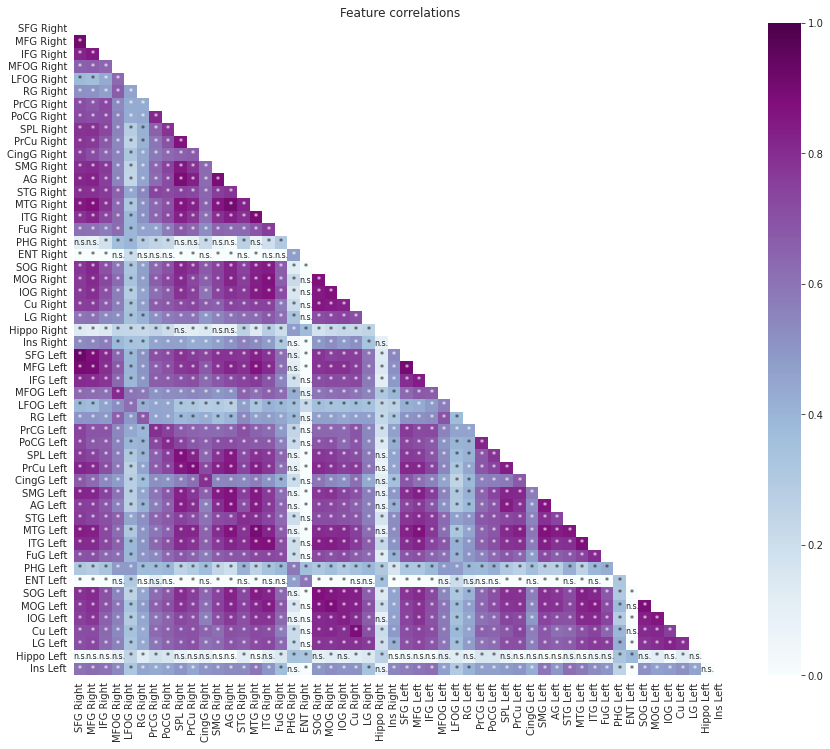

In [62]:
# before correction
pre_corr = new_df[FA_cols[:-1]].corr()
mask = np.zeros_like(pre_corr)
mask[np.triu_indices_from(mask)] = True

p_mat = corr_sig(test_df=new_df[FA_cols[:-1]].copy())

scheme = pd.read_csv('../../SourceData/atlas_labelling_scheme.csv')

lbs = [name.split('_')[1] for name in FA_cols[:-1]]
tick_labels = [scheme[scheme.Label == int(l)]['Abbreviation'].values[0] + ' ' +  scheme[scheme.Label == int(l)]['Hemisphere'].values[0]for l in lbs]


with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 12))
    ax = sns.heatmap(pre_corr, vmin=0, vmax=1, square=True, mask =mask, 
                    xticklabels=tick_labels, yticklabels=tick_labels, 
                    annot=p_mat, annot_kws={"size":8}, cmap="BuPu")
    
    for t in ax.texts:
        if np.float64(t.get_text()) < 0.05:
            t.set_text("*")
        else: 
            t.set_text("n.s.")
        #if 
        #t.set_text(t.get_text() + " %")
plt.title('Feature correlations')
plt.show()

In [63]:
## after correction 
## same but after correction for PMA at scan 
inflection = 36
df_corrected = new_df[FA_cols[:-1]+['PMA_scan']].copy().dropna()
x0 = np.array([min(df_corrected['PMA_scan']), inflection, max(df_corrected['PMA_scan'])])

for col in df_corrected.columns[:-1]:
    myPWLF = pwlf.PiecewiseLinFit(df_corrected['PMA_scan'].values, df_corrected[col].values)
    myPWLF.fit_with_breaks(x0)
        
    ## correct train 
    yHat_train = myPWLF.predict(df_corrected['PMA_scan'].values)
    res_train = df_corrected[col].values - yHat_train
    df_corrected[col] = res_train

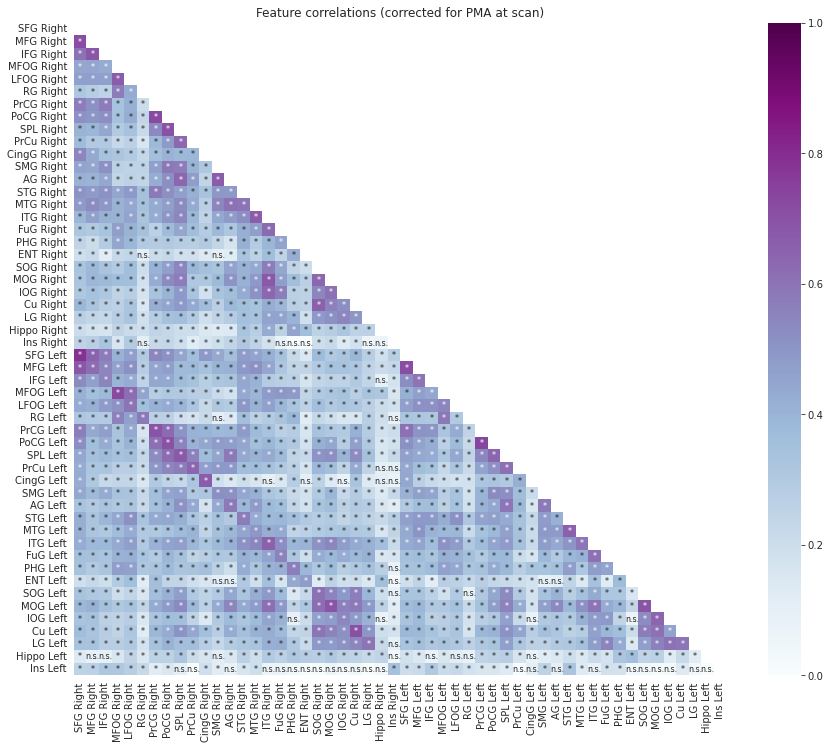

In [64]:
post_corr = df_corrected[FA_cols[:-1]].corr()

mask = np.zeros_like(post_corr)
mask[np.triu_indices_from(mask)] = True

p_mat = corr_sig(test_df=df_corrected[FA_cols[:-1]].copy())

scheme = pd.read_csv('../../SourceData/atlas_labelling_scheme.csv')

lbs = [name.split('_')[1] for name in FA_cols[:-1]]
tick_labels = [scheme[scheme.Label == int(l)]['Abbreviation'].values[0] + ' ' +  scheme[scheme.Label == int(l)]['Hemisphere'].values[0]for l in lbs]


with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 12))
    ax = sns.heatmap(post_corr, vmin=0, vmax=1, square=True, mask =mask, 
                    xticklabels=tick_labels, yticklabels=tick_labels, 
                    annot=p_mat, annot_kws={"size":8}, cmap="BuPu")
    
    for t in ax.texts:
        if np.float64(t.get_text()) < 0.05:
            t.set_text("*")
        else: 
            t.set_text("n.s.")
        #if 
        #t.set_text(t.get_text() + " %")
plt.title('Feature correlations (corrected for PMA at scan)')
plt.show()

### QC with global diffusion 

In [3]:
## need to get the dMRI description first 

df = pd.read_csv('../../DerivedData/cohortA_subjects_clinical.csv', index_col=0)

with open('../../DerivedData/cohorts_subjects_list.pickle', 'rb') as handle:
    cohorts = pickle.load(handle)
    
df = df[df.subject_id.isin(cohorts['A'])]    
qc = pd.read_csv('../../SourceData/release3_subject_info.tsv', sep='\t')

for i, row in df.iterrows():
    
    trans = qc[(qc['participant_id '] == row.subject_id + ' ') & (qc['session_id '] == row.session_id)]['qc_dmri_shard_translation '].values[0]
    rot = qc[(qc['participant_id '] == row.subject_id + ' ') & (qc['session_id '] == row.session_id)]['qc_dmri_shard_rotation '].values[0]
    snr = qc[(qc['participant_id '] == row.subject_id + ' ') & (qc['session_id '] == row.session_id)]['qc_dmri_shard_snr '].values[0]
    outlier = qc[(qc['participant_id '] == row.subject_id + ' ') & (qc['session_id '] == row.session_id)]['qc_dmri_shard_outlier_ratio '].values[0]
    
    df.loc[i, 'qc_dmri_shard_translation'] = trans
    df.loc[i, 'qc_dmri_shard_rotation'] = rot
    df.loc[i, 'qc_dmri_shard_snr'] = snr
    df.loc[i, 'qc_dmri_shard_outlier_ratio'] = outlier

In [4]:
global_diff = pd.read_csv('../../DerivedData/extracted_metrics/global_cortical_FA_metrics_median_minAD.csv', index_col=0)
hemispheres = ['left', 'right']
for metric in ['FA']:
    for i, row in global_diff .iterrows():
        global_diff .loc[i,metric] = np.mean([row['left_{}'.format(metric)], 
                                   row['right_{}'.format(metric)]])
        
out_df = pd.DataFrame(columns=['cohort', 'qc_metric', 'rho', 'p-val'])

idx = 0
for i, cohort in enumerate(cohorts.keys()):
    #print(cohort)
    sub_df = df[df.subject_id.isin(cohorts[cohort])]
    
    sub_global = global_diff[global_diff.subject_id.isin(sub_df.subject_id.values)]
    sub_df = pd.merge(sub_df, sub_global[['subject_id', 'FA']], on='subject_id')
    
        
    #print(sub_df['FA'].values)
    
    qc_metrics = [col  for col in sub_df.columns if 'qc' in col]
    
    for qc in qc_metrics:
        #print(qc)
        res = pg.corr(sub_df[qc], sub_df['FA'])
        #print(res)
        
        new = [cohort, qc, res['r'][0], res['p-val'][0]]
        
        if qc == 'qc_dmri_shard_snr':
            print(res)
        #append row to end of DataFrame
        out_df = out_df.append(pd.Series(new, index=out_df.columns[:len(new)]), ignore_index=True)

    _ , correct_p = pg.multicomp(out_df[out_df.cohort == cohort]['p-val'].values, method='fdr_bh')
    out_df.loc[out_df.cohort == cohort, 'p-val'] = correct_p

           n         r        CI95%     p-val    BF10     power
pearson  295  0.188706  [0.08, 0.3]  0.001127  14.264  0.904696
           n         r        CI95%     p-val   BF10     power
pearson  198  0.140049  [0.0, 0.27]  0.049081  0.608  0.505196
           n         r        CI95%     p-val   BF10     power
pearson  196  0.140424  [0.0, 0.28]  0.049634  0.605  0.503295
           n         r          CI95%     p-val   BF10     power
pearson  126  0.160733  [-0.01, 0.33]  0.072185  0.551  0.438214


In [5]:
out_df

,cohort,qc_metric,rho,p-val
0,A,qc_dmri_shard_translation,0.043287,0.611863
1,A,qc_dmri_shard_rotation,0.076068,0.385249
2,A,qc_dmri_shard_snr,0.188706,0.004509
3,A,qc_dmri_shard_outlier_ratio,0.014047,0.810137
4,B,qc_dmri_shard_translation,0.022761,0.862067
5,B,qc_dmri_shard_rotation,0.056073,0.862067
6,B,qc_dmri_shard_snr,0.140049,0.196322
7,B,qc_dmri_shard_outlier_ratio,-0.012426,0.862067
8,C,qc_dmri_shard_translation,0.021483,0.856948
9,C,qc_dmri_shard_rotation,0.052071,0.856948
